# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------


Mutex is a software package for finding mutual exclusivity and co-occurrence in cancer genes.

__To disregard the FDR and filtering method__, set:
1. leastPatientThreshold to 100
2. test_gene_threshold to 0
3. mpairPercntile to 100
4. cpairPercentile to 100

# BRCA_wustl Segment Losses

# Set parameters

In [5]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-seg-jl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# only load patients listed in this file. Set to None to use all the patients.

geneFile = None
# Only load genes listed in this file. Set to None to use all the patients


output_prefix =  "output/BRCA_wustl-seg-jl-FDR-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"

# If you want to test all pairs without first using the least mutated patients, run the following cell.

In [6]:
minFreq = 0
leastPatientThreshold = 100
test_gene_threshold = 0
closer_than_distance = 100000000
only_filter_copy_distance = True
cFDRthreshold = 0.05
mFDRthreshold = 0.05
pairs_have_dependencies = True

# Otherwise, set the parameters in the following cell and run it.

In [7]:
minFreq = 0
# Only load genes mutated at least this many times.


leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 10
# Test genes that are mutated in at least this percentage of the least mutated patients.



closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. Default is False.

cFDRthreshold = 0.05
# FDR threshold for c-pvalues.

mFDRthreshold = 0.05
# FDR threshold for mutually exclusive pairs.

pairs_have_dependencies = True
#for FDR threshold. Set to True to be conservative, otherwise FDR only controls under independence/positive dependence assumptions

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

1921 genes x 953 patients
*******************************************************************
*                   PLOT A RANDOM DISTRIBUTIONS                   *
*******************************************************************
Median is 444.0


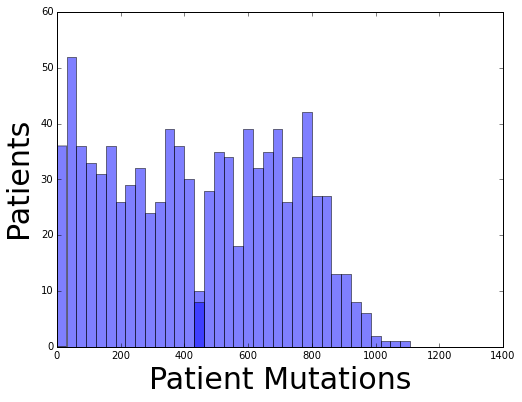

*******************************************************************
*                   PLOT ANOTHER RANDOM DISTRIBUTIONS             *
*******************************************************************


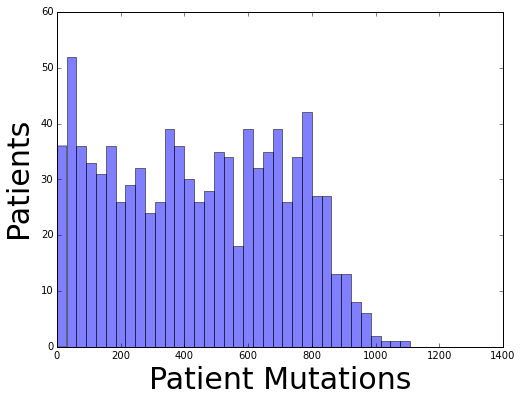

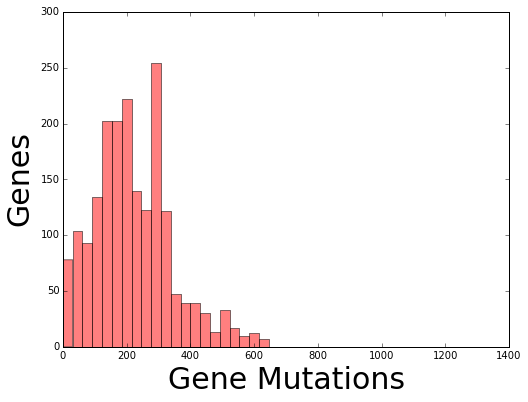

*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


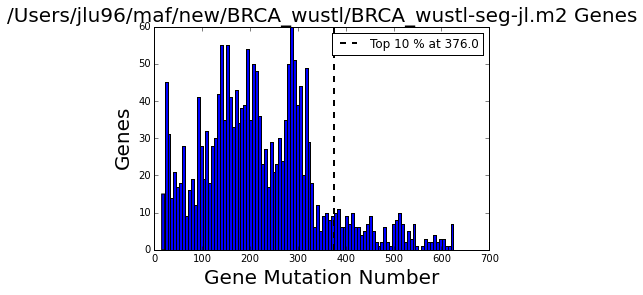

Zoomed into bottom 95 percent region


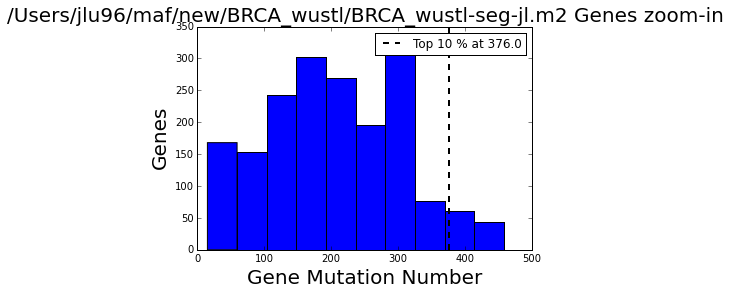


PATIENT MUTATION DISTRIBUTION


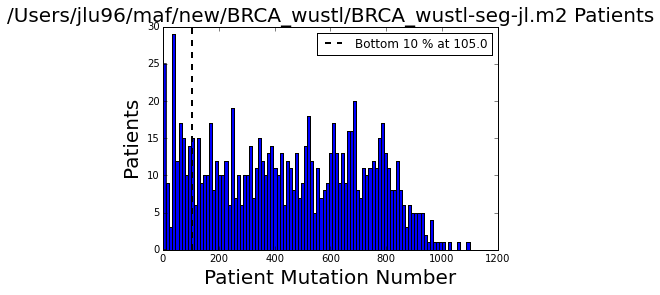

Zoomed into bottom 95 percent region


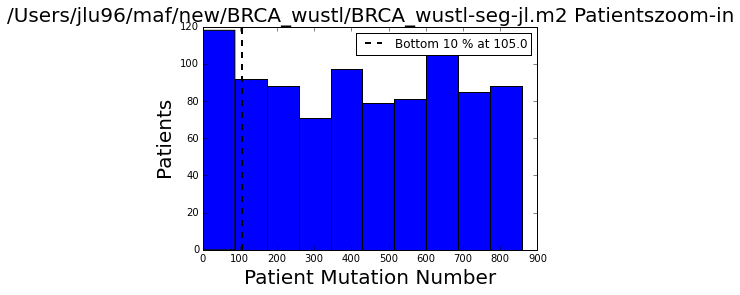

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


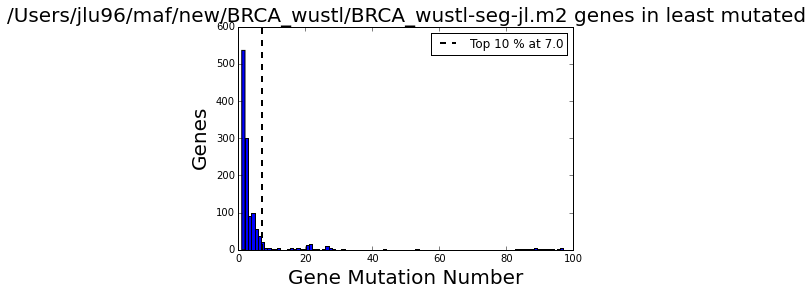


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


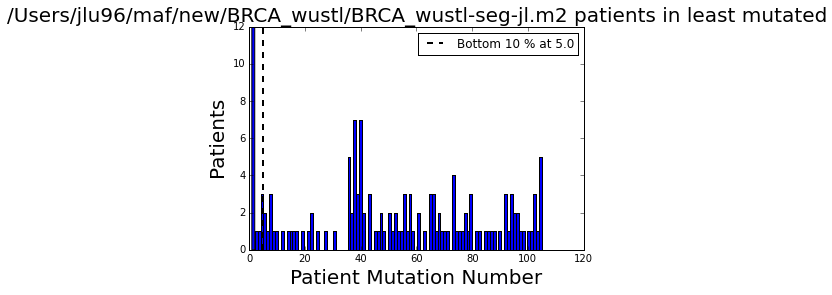

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 1267 genes x 145 patients
The test gene threshold is  10 % of the least mutated patients
Test genes are mutated at least  14  in th least mutated patients
Number of test genes:  106
All genes that weren't found in gene_positions file will not be considered
Number of pairs to test:  4030
Number of pairs is  4030  retrieved in time :  7.48263096809


0

In [47]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
import multi_testing as mt
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)



print "*******************************************************************"
print "*                   PLOT A RANDOM DISTRIBUTIONS                   *"
print "*******************************************************************"

import matplotlib.pyplot as plt

median = stats.scoreatpercentile([len(patientToGenes[p]) for p in patients], 50)
print "Median is", median
lower_values = [len(patientToGenes[p]) for p in patients if len(patientToGenes[p]) < median]
upper_values = [len(patientToGenes[p]) for p in patients if len(patientToGenes[p]) > median + 5]

bins = np.linspace(0, 1200, 40)
plt.figure(figsize=(8,6))
plt.hist(lower_values, alpha=0.5, color='blue', bins=bins)
plt.hist(upper_values, alpha=0.5, color='blue', bins=bins)
plt.xlabel("Patient Mutations", fontsize=30)
plt.ylabel("Patients",fontsize=30)
plt.show()

print "*******************************************************************"
print "*                   PLOT ANOTHER RANDOM DISTRIBUTIONS             *"
print "*******************************************************************"

import matplotlib.pyplot as plt

ps = [len(patientToGenes[p]) for p in patients]
gs = [len(geneToCases[g]) for g in geneToCases]
plt.figure(figsize=(8,6))
plt.hist(ps, alpha=0.5, color='blue', bins=bins)
plt.xlabel("Patient Mutations", fontsize=30)
plt.ylabel("Patients",fontsize=30)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(gs, alpha=0.5, color='red', bins=bins)
plt.xlabel("Gene Mutations", fontsize=30)
plt.ylabel("Genes",fontsize=30)
plt.show()

print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [9]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  8.19253110886
Testing among least mutated patients...
Finished in  4.82517910004
All pairs tested in least mutated patients written to  output/BRCA_wustl-seg-jl-FDR-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


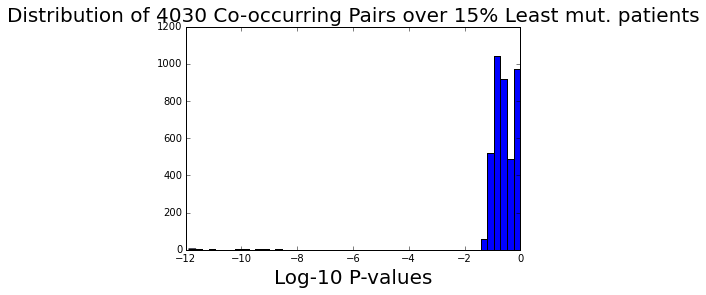

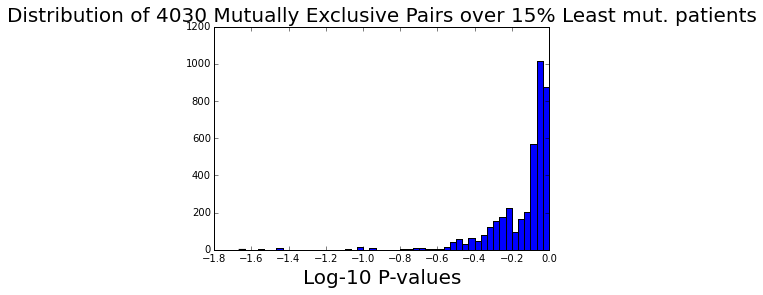

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [13]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.100803562406
Top  10 percent of mutually exclusive pairs :  0.454158205301
Now number of mutex pairs to test  411
Now number of coocurr pairs to test  414
Number of genes  102


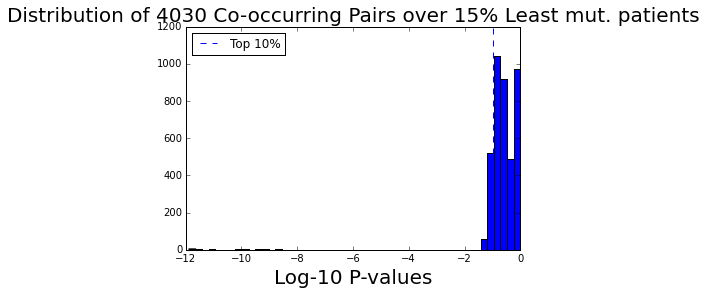

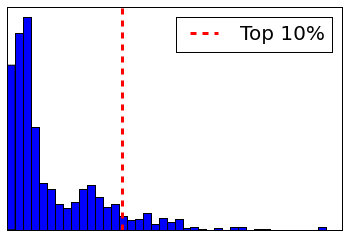

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%", linestyle='dashed', color='b')
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()     # both major and minor ticks are affected
plt.tick_params(left='off', top='off', right='off', bottom='off', 
                   labelleft='off', labeltop='off', labelright='off', labelbottom='off',
               which='both')
 # labels along the bottom edge are off
plt.hist(-1 *logmp, bins=70)
plt.axvline(x= -1 * np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%", linestyle='dashed', color='r',
           linewidth=3)
plt.xlim([0,1])

#plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
#plt.xlabel("Log-10 P-values", fontsize=20)
#plt.ylabel("Count", fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()



### Test new pairs

In [38]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-seg-jl-FDR--pairs-min_cohort_filtered.txt


0

### Plot results

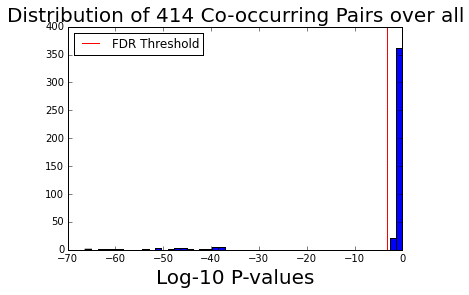

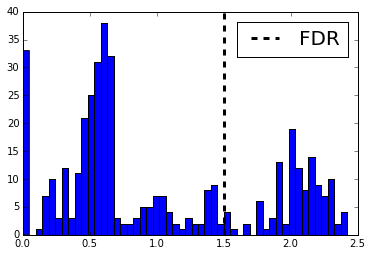

Number significant mutex 0
Number significant coocurr 31


In [44]:
import matplotlib.pyplot as plt

%matplotlib inline

cpairs = [c for c in new_cpairsdict]
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
sig_cpairs, sig_cpvalues, cthreshold = mt.BH(cpairs, cpvalues, Q=cFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_cpairs = set(new_cpairsdict.keys()).difference(set(sig_cpairs))

new_sig_c_dict = new_cpairsdict.copy()
for not_sig_cpair in not_sig_cpairs:
    del new_sig_c_dict[not_sig_cpair]

logcp = np.log10(cpvalues)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One tested co-occurring pair with p=", cpvalues[0]


mpairs = [c for c in new_mpairsdict]
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
sig_mpairs, sig_mpvalues, mthreshold = mt.BH(mpairs, mpvalues, Q=mFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_mpairs = set(new_mpairsdict.keys()).difference(set(sig_mpairs))

new_sig_m_dict = new_mpairsdict.copy()
for not_sig_mpair in not_sig_mpairs:
    del new_sig_m_dict[not_sig_mpair]

logmp = np.log10(mpvalues)

if len(logmp) > 1:
    plt.figure()
    plt.hist(-1 * logmp, bins=50)
    plt.axvline(x=1.5, label="FDR", c='k',linestyle='dashed', linewidth=3)
    #plt.title("Distribution of " + str(len(logmp)) + " Mutually Exclusive Pairs over all", fontsize=20)
    #plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best', fontsize=20)
    plt.show()
elif len(logmp) == 1:
    print "One tested mutex pair with p=", mpvalues[0]




print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)


## Mutual exclusivity info

In [13]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-seg-jl-FDR--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-seg-jl-FDR--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

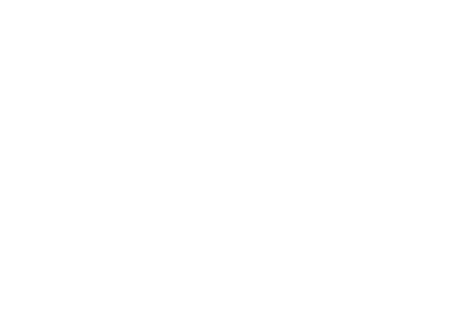

In [14]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [15]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

31  Co-occurring pairs
updated with segment info  output/BRCA_wustl-seg-jl-FDR--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-seg-jl-FDR--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FAM230Closs has 19
RN7SL605Ploss has 12
TBC1D22Aloss has 1
ZNRF3_C22orf31_loss has	1
SEZ6L_RNA5SP495loss has	1
RN7SL757Ploss has 1
AIPL1_FAM64A_KIloss has	1
HS3ST3A1_MIR548loss has	1
MAP2K4_MIR744loss has 1
MYH13_MYH8_MYH4loss has	1
CYB5D1_CHD3_KCNloss has	1
PPM1F_TOP3B_VPRloss has	1
YWHAEloss has 1
IGLL1_GUSBP11_Rloss has	1
LINC00898loss has 1
LARGEloss has 1
RN7SL162P_CHEK2loss has	1
LINC00670_MYOCDloss has	1
MN1_PITPNBloss has 1
WSCD1loss has 1
OR11H1_POTEH_KCloss has	1
HMGXB4_TOM1_MIRloss has	1
TXN2_FOXRED2_EIloss has	1
DOC2B_RPH3AL_C1loss has	1
ISXloss has 1
CRK_MYO1C_INPP5loss has	1
STX8_USP43_DHRSloss has	1
DNAH9_ZNF18_RPLloss has	1
MIR3201_FAM19A5loss has	1
TTC28loss has 1
MAPK1_RNA5SP493loss has 1
PEX26_TUBA8_US

0

# Draw co-occurrence network

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


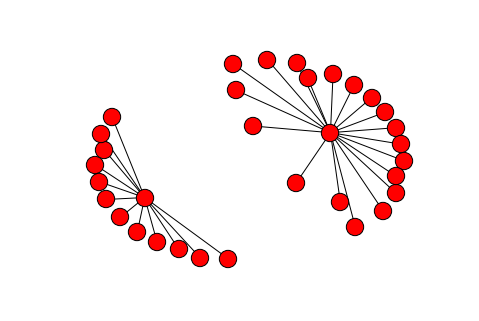


***********************
COMPONENT 0
***********************
Number of nodes  20
Number of edges  19
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
FAM230Closs : 1.0 19
ISXloss : 0.05 1
MN1_PITPNBloss : 0.05 1
---
Writing nodes to:  output/BRCA_wustl-seg-jl-FDR--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  13
Number of edges  12
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
RN7SL605Ploss : 1.0 12
WSCD1loss : 0.08 1
YWHAEloss : 0.08 1
---
Writing nodes to:  output/BRCA_wustl-seg-jl-FDR--cpairs-min_cohort_filtered_network_comp1.txt


In [16]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [17]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********TRIPLET CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  31
Pair info of triplets initialized
0  triplets calculated in  0.00110816955566
Including sorting time  0.00118207931519


# BRCA_wustl SNV

# Set parameters

In [18]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# only load patients listed in this file. Set to None to use all the patients.

geneFile = None
# Only load genes listed in this file. Set to None to use all the patients


output_prefix =  "output/BRCA_wustl-som-FDR-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"

# If you want to test all pairs without first using the least mutated patients, run the following cell.

In [19]:
minFreq = 0
leastPatientThreshold = 100
test_gene_threshold = 0
closer_than_distance = 100000000
only_filter_copy_distance = True
cFDRthreshold = 0.05
mFDRthreshold = 0.05
pairs_have_dependencies = True

# Otherwise, set the parameters in the following cell and run it.

In [20]:
minFreq = 0
# Only load genes mutated at least this many times.


leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 2
# Test genes that are mutated in at least this percentage of the least mutated patients.



closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. Default is False.

cFDRthreshold = 0.05
# FDR threshold for c-pvalues.

mFDRthreshold = 0.05
# FDR threshold for mutually exclusive pairs.

pairs_have_dependencies = True
#for FDR threshold. Set to True to be conservative, otherwise FDR only controls under independence/positive dependence assumptions

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

17637 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


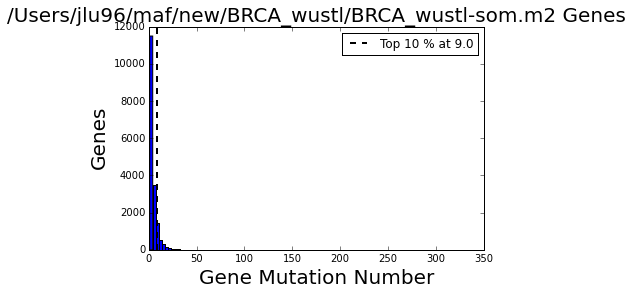

Zoomed into bottom 95 percent region


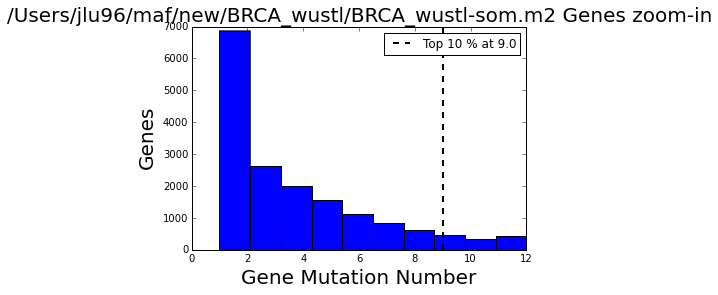


PATIENT MUTATION DISTRIBUTION


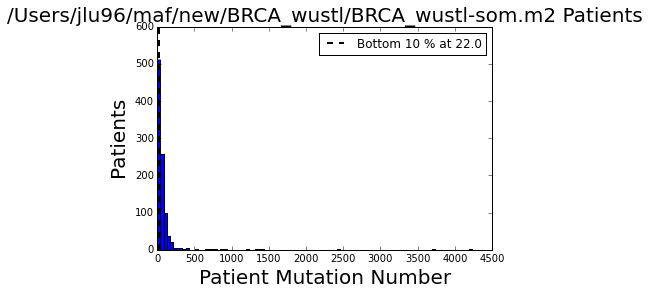

Zoomed into bottom 95 percent region


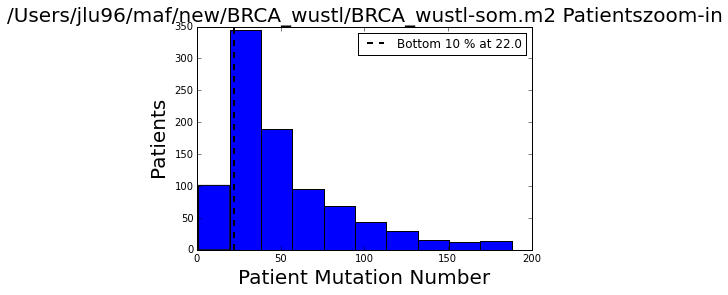

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


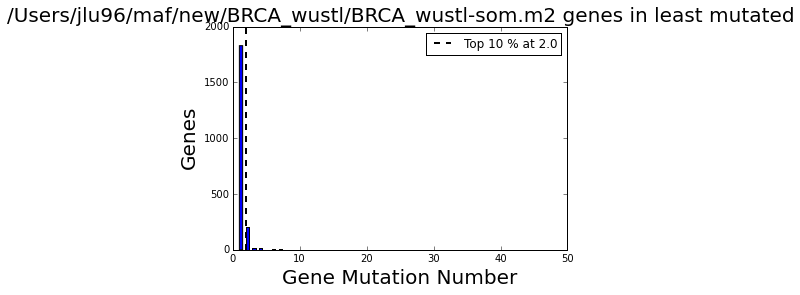


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


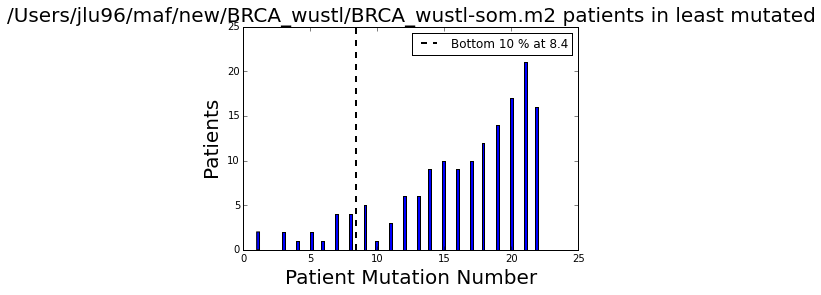

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 2081 genes x 155 patients
The test gene threshold is  2 % of the least mutated patients
Test genes are mutated at least  3  in th least mutated patients
Number of test genes:  49
Number of pairs to test:  1176
Number of pairs is  1176  retrieved in time :  0.605500936508


0

In [21]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
import multi_testing as mt
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [22]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  0.937412023544
Testing among least mutated patients...
Finished in  0.915499925613
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-FDR-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

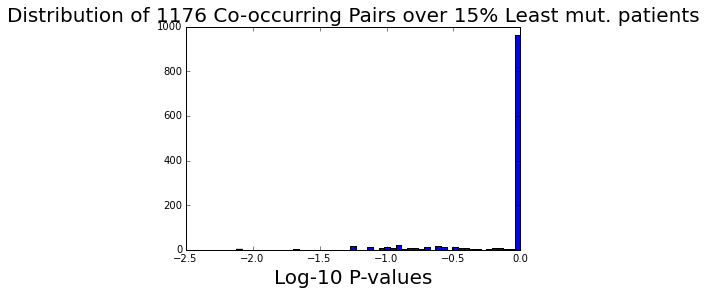

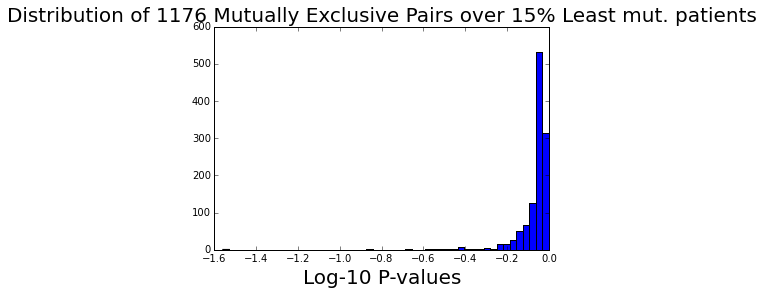

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [24]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.207396554245
Top  10 percent of mutually exclusive pairs :  0.747662312754
Now number of mutex pairs to test  122
Now number of coocurr pairs to test  121
Number of genes  49


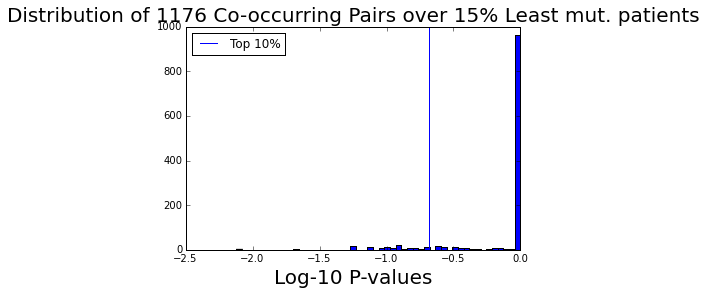

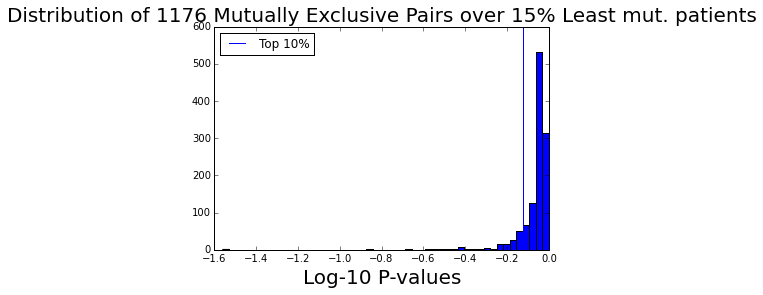

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [26]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som-FDR--pairs-min_cohort_filtered.txt


0

### Plot results

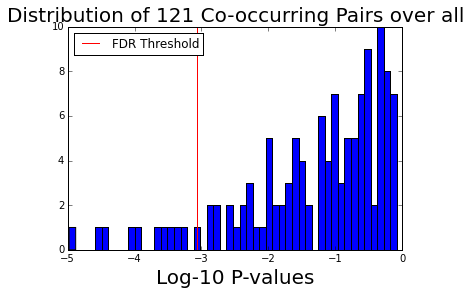

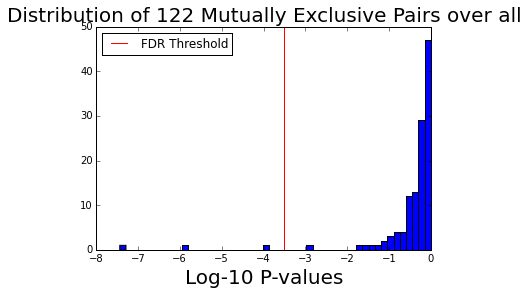

Number significant mutex 3
Number significant coocurr 10


In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

cpairs = [c for c in new_cpairsdict]
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
sig_cpairs, sig_cpvalues, cthreshold = mt.BH(cpairs, cpvalues, Q=cFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_cpairs = set(new_cpairsdict.keys()).difference(set(sig_cpairs))

new_sig_c_dict = new_cpairsdict.copy()
for not_sig_cpair in not_sig_cpairs:
    del new_sig_c_dict[not_sig_cpair]

logcp = np.log10(cpvalues)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One tested co-occurring pair with p=", cpvalues[0]


mpairs = [c for c in new_mpairsdict]
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
sig_mpairs, sig_mpvalues, mthreshold = mt.BH(mpairs, mpvalues, Q=mFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_mpairs = set(new_mpairsdict.keys()).difference(set(sig_mpairs))

new_sig_m_dict = new_mpairsdict.copy()
for not_sig_mpair in not_sig_mpairs:
    del new_sig_m_dict[not_sig_mpair]

logmp = np.log10(mpvalues)

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp)) + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One tested mutex pair with p=", mpvalues[0]




print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)


## Mutual exclusivity info

In [28]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

Gene  GPR98  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
*********MUTUAL EXCLUSIVITY INFO**********

3  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som-FDR--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-FDR--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
TP53 has 3
CDH1 has 1
MAP3K1 has 1
GATA3 has 1

**********SINGLE CYTOBANDS**********
['17p13.1'] has 3
['5q11.2'] has 1
['16q22.1'] has 1
['10p14'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p13.1']"]) has 1
frozenset(["['10p14']", "['17p13.1']"]) has 1
frozenset(["['16q22.1']", "['17p13.1']"]) has 1


0

# Draw mutual exclusivity network

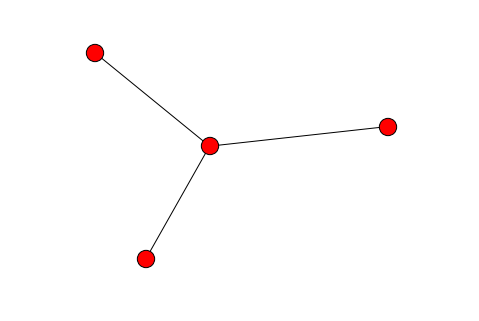


***********************
COMPONENT 0
***********************
Number of nodes  4
Number of edges  3
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
TP53 : 1.0 3
CDH1 : 0.33 1
MAP3K1 : 0.33 1
---
Writing nodes to:  output/BRCA_wustl-som-FDR--mpairs-min_cohort_filtered_network_comp0.txt


In [29]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [30]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

10  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som-FDR--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-FDR--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
C9orf43 has 3
CACNA1D has 3
TTN has 2
SACS has 2
MUC16 has 2
KIF16B has 1
WNK1 has 1
PLCB4 has 1
MUC5B has 1
GOLGA6L2 has 1
PRKDC has 1
GPR98 has 1
NCOR1 has 1

**********SINGLE CYTOBANDS**********
['9q31.3'] has 3
['3p21.1'] has 3
['13q12.12'] has 2
['19p13.2'] has 2
['2q31.2'] has 2
['12p13.33'] has 1
['15q11.2'] has 1
['20p12.1'] has 1
[] has 1
['11p15.5'] has 1
['8q11.1'] has 1
['20p12.3', '20p12.2'] has 1
['17p11.2'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['15q11.2']", '[]']) has 1
frozenset(["['13q12.12']", "['19p13.2']"]) has 1
frozenset(["['19p13.2']", "['2q31.2']"]) has 1
frozenset(["['20p12.1']", "['17p11.2']"]) has 1
frozenset(["['9q31.3']", "['3p21.1']"]) has 1
frozenset(["['3p21.1']", "['2q31.2']"

0

# Draw co-occurrence network

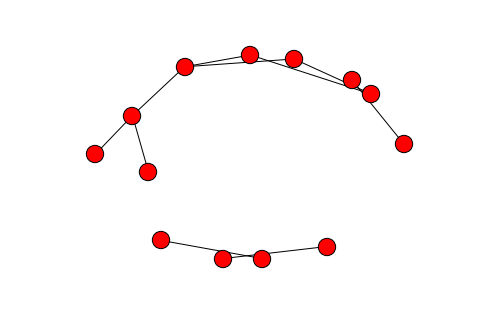


***********************
COMPONENT 0
***********************
Number of nodes  7
Number of edges  7
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
C9orf43 : 0.5 3
CACNA1D : 0.5 3
TTN : 0.33 2
---
Writing nodes to:  output/BRCA_wustl-som-FDR--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
KIF16B : 1.0 1
NCOR1 : 1.0 1
---
Writing nodes to:  output/BRCA_wustl-som-FDR--cpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 2
Gene: Degree Centrality   Degree
WNK1 : 1.0 1
PLCB4 : 1.0 1
---
Writing nodes to:  output/BRCA_wustl-som-FDR--cpairs-min_cohort_filtered_network_comp2.txt

***********************
COMPONENT 3
***********************
Numb

In [31]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [32]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********TRIPLET CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  13
Pair info of triplets initialized
0  triplets calculated in  0.0005202293396
Including sorting time  0.000630140304565


# BRCA_wustl SOMATIC + Segment Losses

# Set parameters

In [68]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-seg-jl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# only load patients listed in this file. Set to None to use all the patients.

geneFile = None
# Only load genes listed in this file. Set to None to use all the patients


output_prefix =  "output/BRCA_wustl-som-seg-jl-FDR-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"

# If you want to test all pairs without first using the least mutated patients, run the following cell.

In [69]:
minFreq = 0
leastPatientThreshold = 100
test_gene_threshold = 0
closer_than_distance = 100000000
only_filter_copy_distance = True
cFDRthreshold = 0.05
mFDRthreshold = 0.05
pairs_have_dependencies = True

# Otherwise, set the parameters in the following cell and run it.

In [70]:
minFreq = 0
# Only load genes mutated at least this many times.


leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 3
# Test genes that are mutated in at least this percentage of the least mutated patients.



closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. Default is False.

cFDRthreshold = 0.05
# FDR threshold for c-pvalues.

mFDRthreshold = 0.05
# FDR threshold for mutually exclusive pairs.

pairs_have_dependencies = True
#for FDR threshold. Set to True to be conservative, otherwise FDR only controls under independence/positive dependence assumptions

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

19558 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


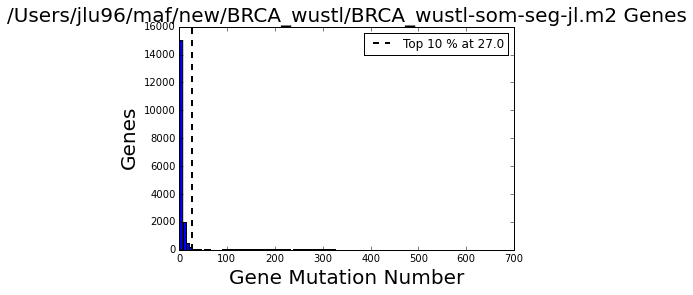

Zoomed into bottom 95 percent region


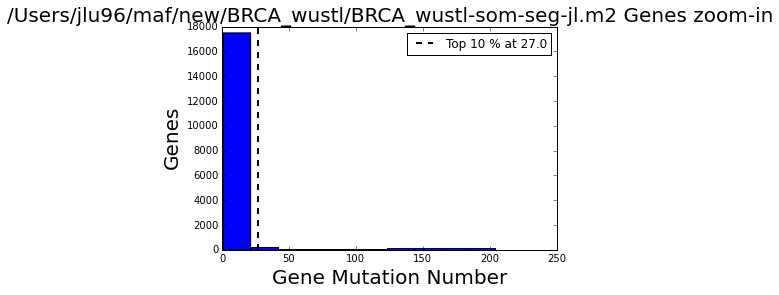


PATIENT MUTATION DISTRIBUTION


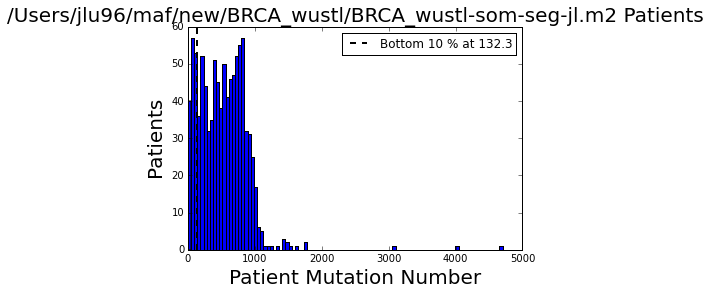

Zoomed into bottom 95 percent region


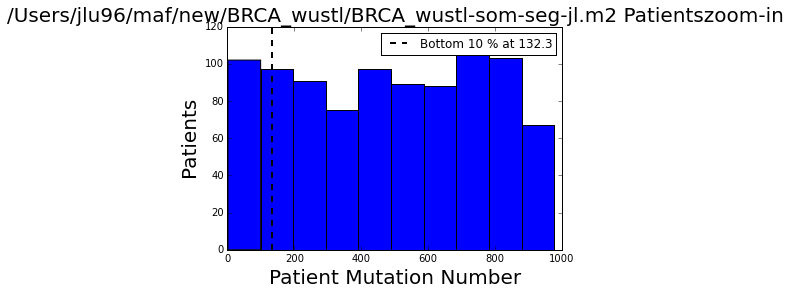

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


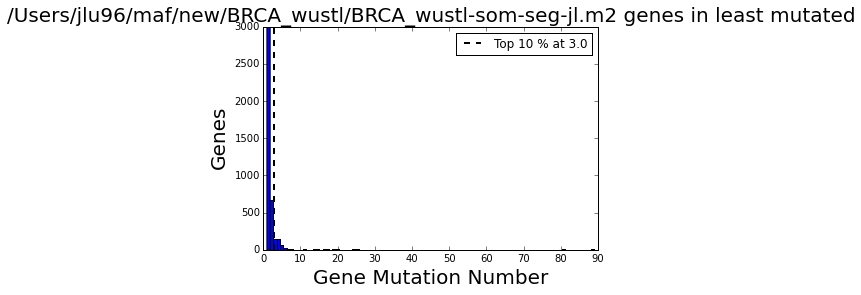


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


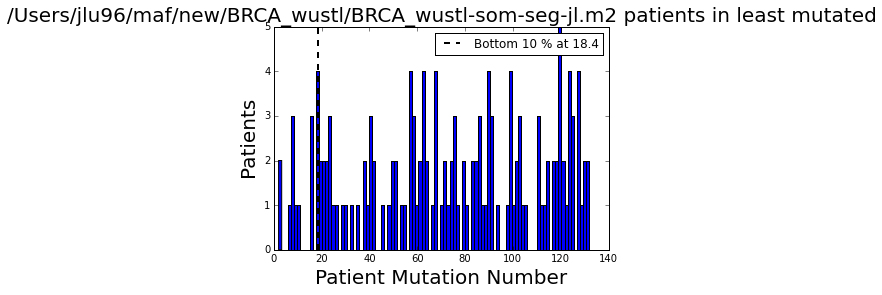

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 4177 genes x 145 patients
The test gene threshold is  3 % of the least mutated patients
Test genes are mutated at least  4  in th least mutated patients
Number of test genes:  374
All genes that weren't found in gene_positions file will not be considered
Gene  GPR98  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Gene  MST1P9  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Number of pairs to test:  63069
Number of pairs is  63069  retrieved in time :  7.97479510307


0

In [71]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
import multi_testing as mt
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [72]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  53.6148700714
Testing among least mutated patients...
Finished in  73.2382230759
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-seg-jl-FDR-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

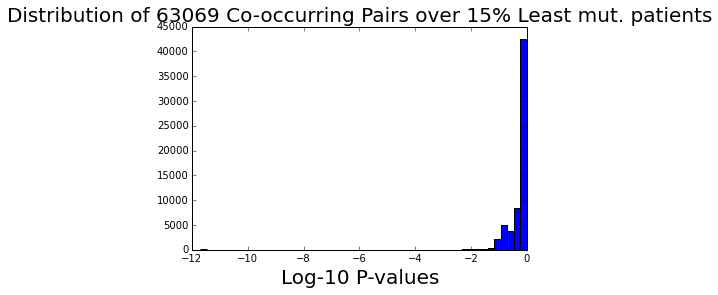

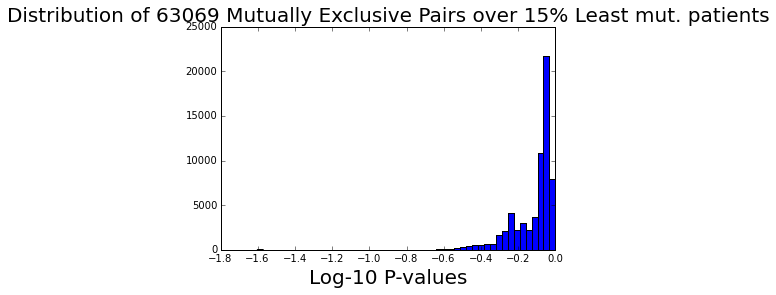

In [73]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [74]:
cpairPercentile = 5
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 5

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  5 percent of cooccurring pairs:  0.106002829745
Top  5 percent of mutually exclusive pairs :  0.454596036898
Now number of mutex pairs to test  3325
Now number of coocurr pairs to test  3026
Number of genes  369


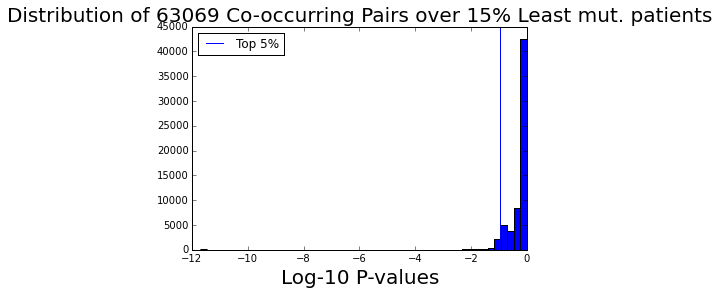

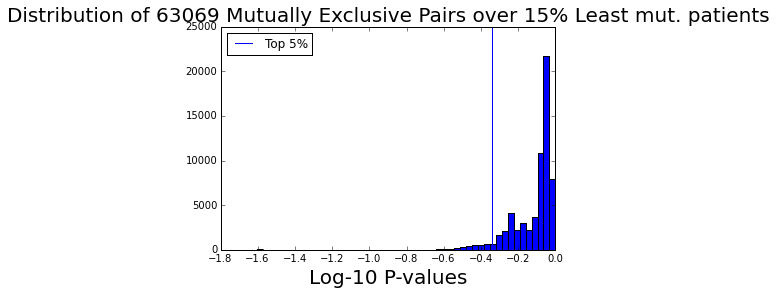

In [75]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [76]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som-seg-jl-FDR--pairs-min_cohort_filtered.txt


0

### Plot results

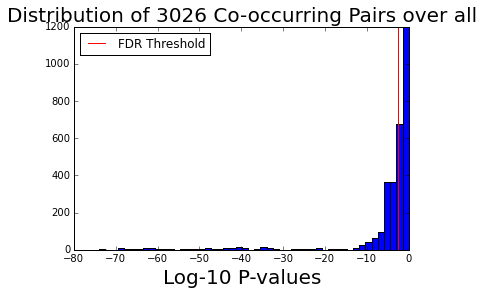

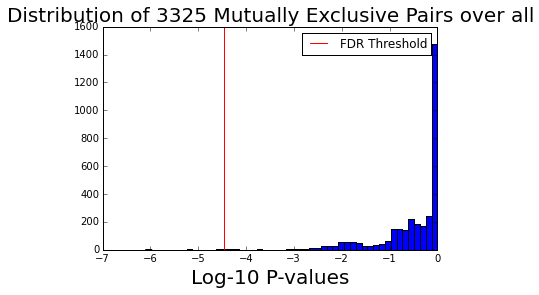

Number significant mutex 19
Number significant coocurr 1257


In [77]:
import matplotlib.pyplot as plt

%matplotlib inline

cpairs = [c for c in new_cpairsdict]
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
sig_cpairs, sig_cpvalues, cthreshold = mt.BH(cpairs, cpvalues, Q=cFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_cpairs = set(new_cpairsdict.keys()).difference(set(sig_cpairs))

new_sig_c_dict = new_cpairsdict.copy()
for not_sig_cpair in not_sig_cpairs:
    del new_sig_c_dict[not_sig_cpair]

logcp = np.log10(cpvalues)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One tested co-occurring pair with p=", cpvalues[0]


mpairs = [c for c in new_mpairsdict]
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
sig_mpairs, sig_mpvalues, mthreshold = mt.BH(mpairs, mpvalues, Q=mFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_mpairs = set(new_mpairsdict.keys()).difference(set(sig_mpairs))

new_sig_m_dict = new_mpairsdict.copy()
for not_sig_mpair in not_sig_mpairs:
    del new_sig_m_dict[not_sig_mpair]

logmp = np.log10(mpvalues)

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp)) + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One tested mutex pair with p=", mpvalues[0]




print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)


## Mutual exclusivity info

In [78]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

19  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som-seg-jl-FDR--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-jl-FDR--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
MAP3K1 has 16
CDH1 has 2
KCNJ12loss has 1
DHRS7B_TMEM11_Rloss has	1
EVPLL_KRT17P2_Kloss has	1
CYB5D1_CHD3_KCNloss has	1
PPP2R2A_SDAD1P1loss has	1
MPRIP_RN7SL775Ploss has	1
STX8_USP43_DHRSloss has	1
PIK3CA has 1
MAP2K3loss has 1
WSCD1loss has 1
CCDC144CP_UPF3Aloss has	1
SCN8A_ANKRD33_Aloss has	1
USP22loss has 1
CCDC144NLloss has 1
DUSP4loss has 1
TOM1L2_LRRC48_Aloss has	1
SLC5A10_FAM83G_loss has	1
B9D1_MIR1180_MAloss has	1
C17orf51_UBBP4_loss has	1
SPECC1loss has 1

**********SINGLE CYTOBANDS**********
['5q11.2'] has 16
['17p11.2']loss has 12
['16q22.1'] has 2
['17p13.1']loss has 2
['8p12']loss has 1
['17p11.2', '17p11.1']loss has 1
['3q26.33'] has 1
['12q13.13']loss has 1
['8p21.2', '8p21.1', '8p12']l

0

# Draw mutual exclusivity network

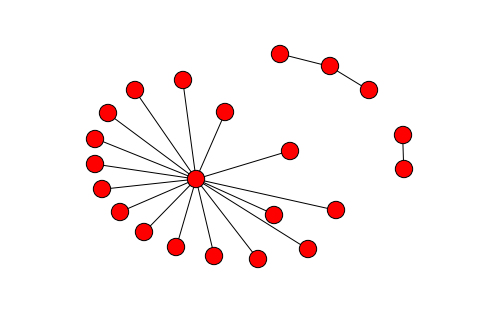


***********************
COMPONENT 0
***********************
Number of nodes  17
Number of edges  16
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
MAP3K1 : 1.0 16
WSCD1loss : 0.06 1
CCDC144NLloss : 0.06 1
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-FDR--mpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  3
Number of edges  2
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
CDH1 : 1.0 2
DUSP4loss : 0.5 1
PPP2R2A_SDAD1P1_BNIP3L_PNMA2_DPYSL2_ADRA1A_MIR548H4_STMN4_TRIM35_PTK2B_CHRNA2_EPHX2_CLU_SCARA3_MIR3622B_CCDC25_ESCO2_PBK_SCARA5_MIR4287_NUGGC_ELP3_PNOC_ZNF395_FBXO16_FZD3_MIR4288_RNA5SP259_EXTL3_INTS9_HMBOX1_RNA5SP260_KIF13Bloss : 0.5 1
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-FDR--mpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
***********************
Number of nodes  2
Number of edges  1
---

In [79]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [80]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

1257  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som-seg-jl-FDR--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-jl-FDR--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
SNORD22loss has 62
MAP3K1_SETD9_MIloss has	46
MIR582loss has 46
PDE4Dloss has 46
HTR1A_RNF180_RGloss has	46
PLK2_GAPT_MIR54loss has	46
PIK3R1_SLC30A5_loss has	46
ESM1_GZMK_GZMA_loss has	46
FKSG52_PART1_DEloss has	46
MAST4_CD180loss has 46
RN7SL605Ploss has 40
KCNQ1DNloss has 40
CDH1 has 38
RN7SL811Ploss has 36
NAA38loss has 36
KLRB1_CLEC2D_CLloss has	32
OR4F17_PPAP2C_Mloss has	31
RN7SL676Ploss has 31
PIK3CA has 29
VWF_RN7SL69P_CDloss has	29
BET1L_SCGB1C1_Oloss has	28
LIPJ_LIPF_LIPK_loss has	28
PTENloss has 21
KLLNloss has 21
ATAD1_CFL1P1_RNloss has	21
FAM230Closs has 20
LINC00359_RN7SKloss has	20
AIPL1_FAM64A_KIloss has	19
DOC2B_RPH3AL_C1loss has	19
TP53 has 19
YWHAEloss has 19
ADM_AMPD3_RNU6Aloss has	18
GALNT1

0

# Draw co-occurrence network

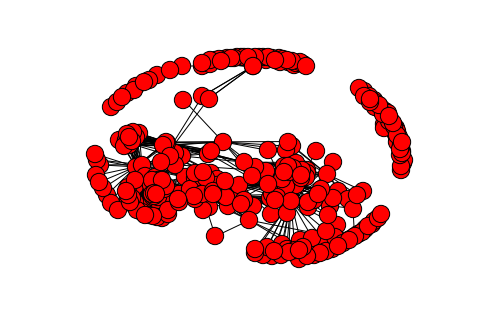


***********************
COMPONENT 0
***********************
Number of nodes  236
Number of edges  1180
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
SNORD22loss : 0.26 62
MIR582loss : 0.2 46
PDE4Dloss : 0.2 46
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-FDR--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  40
Number of edges  67
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
CDH1 : 0.97 38
PIK3CA : 0.74 29
CALB2_ZNF23_ZNF19_CHST4_TAT_MARVELD3_PHLPP2_SNORA70D_AP1G1_SNORD71_ATXN1L_IST1_ZNF821_PKD1L3_DHODH_TXNL4B_HP_HPR_DHX38_PMFBP1loss : 0.05 2
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-FDR--cpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
***********************
Number of nodes  9
Number of edges  8
---
Top 3 nodes by degree centraliy in component 2
Gene: Degree Centrality   Degree
APOB : 0

In [81]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [82]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********TRIPLET CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  1276
Pair info of triplets initialized
1181  triplets calculated in  1.01505208015
Including sorting time  1.01884102821
1181  of type  CooccurringCooccurringCooccurring
Triplets written to  output/BRCA_wustl-som-seg-jl-FDR--triplets-CooccurringCooccurringCooccurring.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-jl-FDR--triplets-CooccurringCooccurringCooccurring.txt
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
RN7SL605Ploss has 209
SNORD22loss has 192
KCNQ1DNloss has 118
TP53 has 89
KLRB1_CLEC2D_CLloss has	84
VWF_RN7SL69P_CDloss has	83
RN7SL676Ploss has 79
ZFP42_TRIML2_TRloss has	65
TENM3_MIR1305loss has 65
RN7SKP13loss has 65
LINC00290loss has 65
CBLN2_NETO1_RNAloss has	62
ZNF516_LINC0090loss has	62
ZNF407_ZADH2_TSloss has	62
BET1L_SCGB1C1_Oloss has	59
PLEKHA5_RN7SL45loss has	57
PLCZ1_CAPZA3loss has 57
LINC00359_RN7SKloss has	56
TMX3_CCDC102Bloss has 53
DOK6_CD226_RTTNloss has	53
MAP3K1_SETD9_MIloss has	49
MIR58

# BRCA_wustl Somatic and Segment Gains + Losses

# Set parameters

In [98]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-seg-gl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# only load patients listed in this file. Set to None to use all the patients.

geneFile = None
# Only load genes listed in this file. Set to None to use all the patients


output_prefix =  "output/BRCA_wustl-som-seg-gl-FDR-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
gene_c_file = new_cpairfile[:-4] + "_genes.txt"
gene_m_file = new_mpairfile[:-4] + "_genes.txt"
cyto_c_file = new_cpairfile[:-4] + "_cytobands.txt"
cyto_m_file = new_mpairfile[:-4] + "_cytobands.txt"
cytopairs_c_file = new_cpairfile[:-4] + "_cytoband-pairs.txt"
cytopairs_m_file = new_mpairfile[:-4] + "_cytoband-pairs.txt"
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"

# If you want to test all pairs without first using the least mutated patients, run the following cell.

In [84]:
minFreq = 0
leastPatientThreshold = 100
test_gene_threshold = 0
closer_than_distance = 100000000
only_filter_copy_distance = True
cFDRthreshold = 0.05
mFDRthreshold = 0.05
pairs_have_dependencies = True

# Otherwise, set the parameters in the following cell and run it.

In [85]:
minFreq = 0
# Only load genes mutated at least this many times.


leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 5
# Test genes that are mutated in at least this percentage of the least mutated patients.



closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. Default is False.

cFDRthreshold = 0.05
# FDR threshold for c-pvalues.

mFDRthreshold = 0.05
# FDR threshold for mutually exclusive pairs.

pairs_have_dependencies = True
#for FDR threshold. Set to True to be conservative, otherwise FDR only controls under independence/positive dependence assumptions

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

21479 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


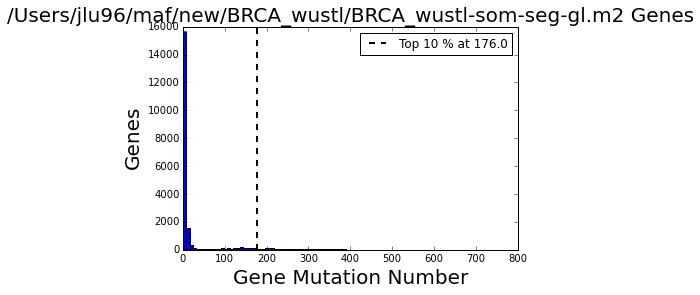

Zoomed into bottom 95 percent region


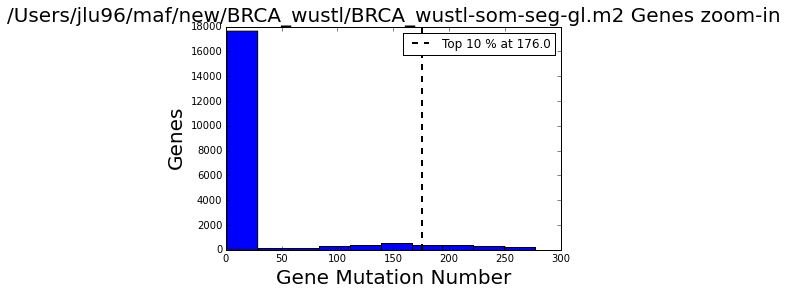


PATIENT MUTATION DISTRIBUTION


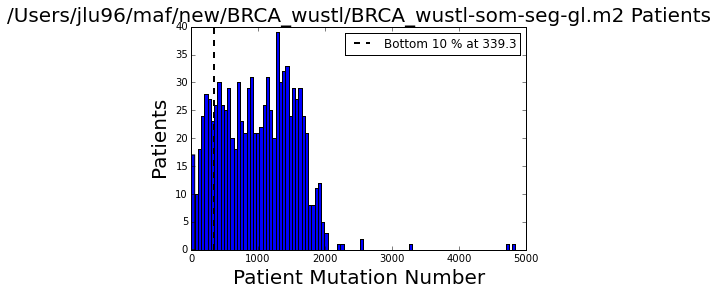

Zoomed into bottom 95 percent region


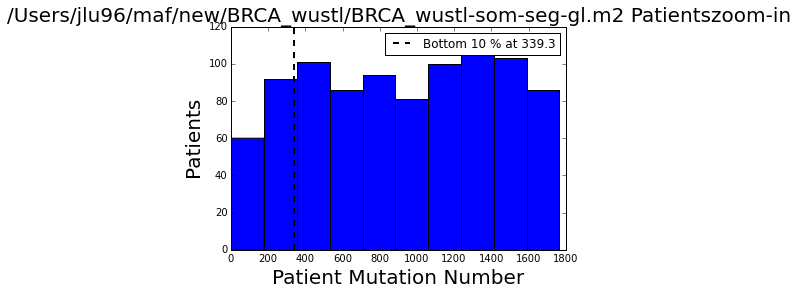

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


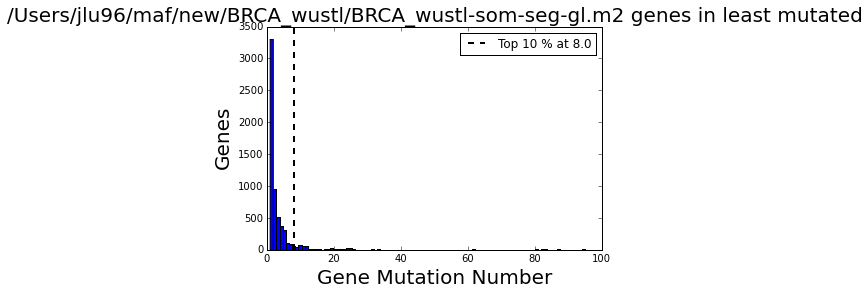


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


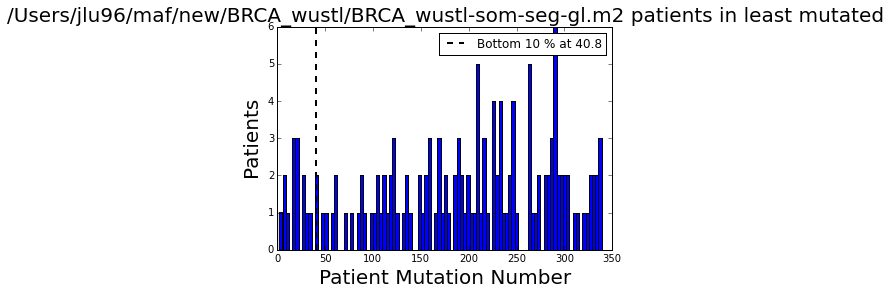

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 6281 genes x 145 patients
The test gene threshold is  5 % of the least mutated patients
Test genes are mutated at least  7  in th least mutated patients
Number of test genes:  731
All genes that weren't found in gene_positions file will not be considered
Number of pairs to test:  234516
Number of pairs is  234516  retrieved in time :  24.3915169239


0

In [86]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
import multi_testing as mt
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [87]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  427.304861069
Testing among least mutated patients...
Finished in  344.782320023
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-seg-gl-FDR-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

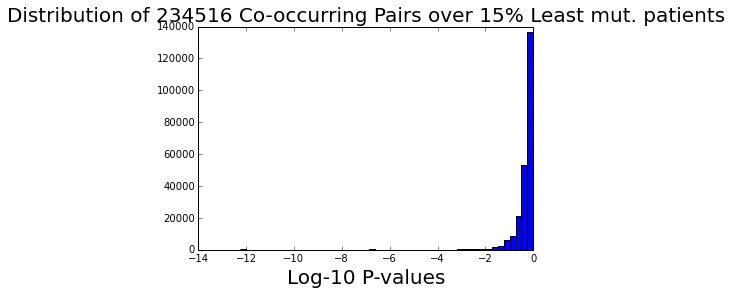

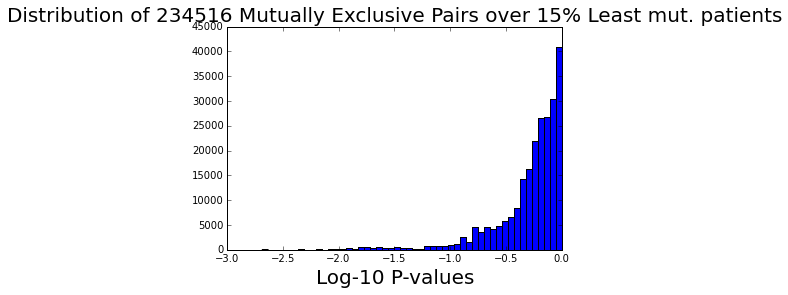

In [88]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [102]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 3

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.181803597087
Top  3 percent of mutually exclusive pairs :  0.0690614606359
Now number of mutex pairs to test  7244
Now number of coocurr pairs to test  23461
Number of genes  731


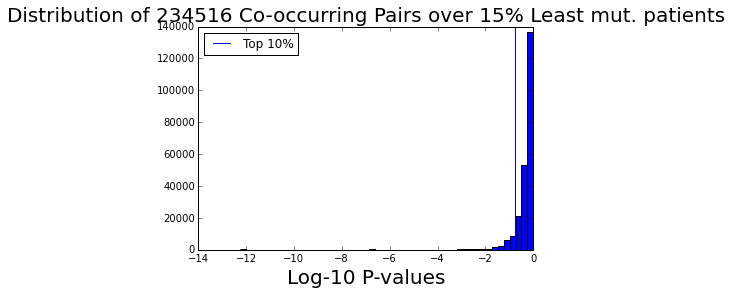

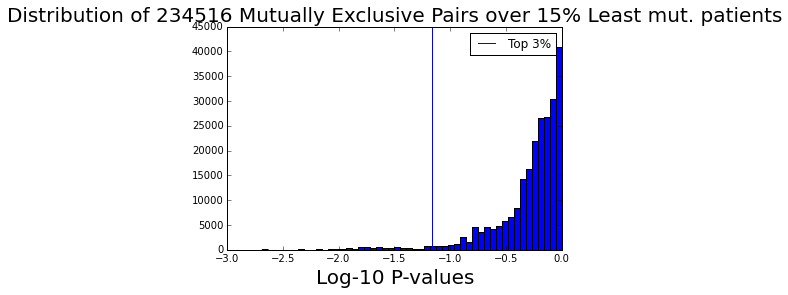

In [103]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [104]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som-seg-gl-FDR--pairs-min_cohort_filtered.txt


0

### Plot results

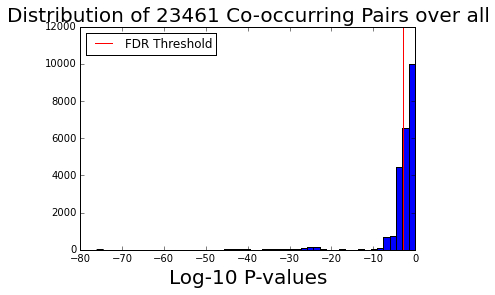

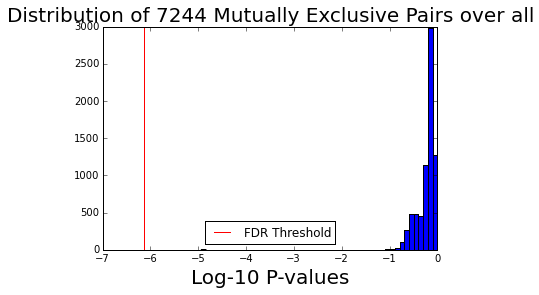

Number significant mutex 0
Number significant coocurr 7912


In [105]:
import matplotlib.pyplot as plt

%matplotlib inline

cpairs = [c for c in new_cpairsdict]
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
sig_cpairs, sig_cpvalues, cthreshold = mt.BH(cpairs, cpvalues, Q=cFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_cpairs = set(new_cpairsdict.keys()).difference(set(sig_cpairs))

new_sig_c_dict = new_cpairsdict.copy()
for not_sig_cpair in not_sig_cpairs:
    del new_sig_c_dict[not_sig_cpair]

logcp = np.log10(cpvalues)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One tested co-occurring pair with p=", cpvalues[0]


mpairs = [c for c in new_mpairsdict]
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
sig_mpairs, sig_mpvalues, mthreshold = mt.BH(mpairs, mpvalues, Q=mFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_mpairs = set(new_mpairsdict.keys()).difference(set(sig_mpairs))

new_sig_m_dict = new_mpairsdict.copy()
for not_sig_mpair in not_sig_mpairs:
    del new_sig_m_dict[not_sig_mpair]

logmp = np.log10(mpvalues)

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp)) + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One tested mutex pair with p=", mpvalues[0]




print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)


## Mutual exclusivity info

In [106]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])+ suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "Writing single genes output to ", gene_m_file
with open(gene_m_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["Gene", "Pairs"])
    for gene, pairs in sorted_genes:
        writer.writerow([gene, len(pairs)])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])
    
print "Writing single cytobands output to ", cyto_m_file
with open(cyto_m_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["Cytoband", "Pairs"])
    for cytoband, pairs in sorted_cytobands:
        writer.writerow([cytoband, len(pairs)])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])
    
print "Writing paired cytobands output to ", cytopairs_m_file
with open(cytopairs_m_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["Cytoband1", "Cytoband2", "Number"])
    for cytopair, pairs in sorted_cytotuples:
        cyto1, cyto2 = tuple(cytopair)
        writer.writerow([cyto1, cyto2, len(pairs)])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som-seg-gl-FDR--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-gl-FDR--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
Writing single genes output to  output/BRCA_wustl-som-seg-gl-FDR--mpairs-min_cohort_filtered_genes.txt

**********SINGLE CYTOBANDS**********
Writing single cytobands output to  output/BRCA_wustl-som-seg-gl-FDR--mpairs-min_cohort_filtered_cytobands.txt

**********PAIRED CYTOBANDS**********
Writing paired cytobands output to  output/BRCA_wustl-som-seg-gl-FDR--mpairs-min_cohort_filtered_cytoband-pairs.txt


0

# Draw mutual exclusivity network

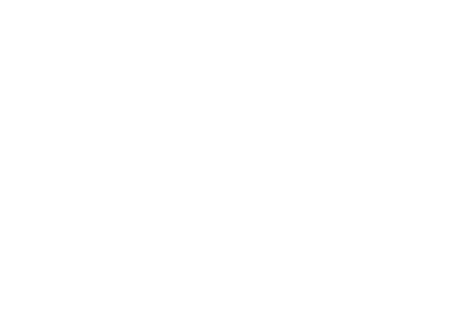

In [107]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [110]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if "-".join(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict["-".join(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict["-".join(info0['Cytobands']) + suffix0].add(pair)
    if "-".join(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict["-".join(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict["-".join(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset(["-".join(info0['Cytobands']) + suffix0, "-".join(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "Writing single genes output to ", gene_c_file
with open(gene_c_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["Gene", "Pairs"])
    for gene, pairs in sorted_genes:
        writer.writerow([gene, len(pairs)])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])
    
print "Writing single cytobands output to ", cyto_c_file
with open(cyto_c_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["Cytoband", "Pairs"])
    for cytoband, pairs in sorted_cytobands:
        writer.writerow([cytoband, len(pairs)])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])
    
print "Writing paired cytobands output to ", cytopairs_c_file
with open(cytopairs_c_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["Cytoband1", "Cytoband2", "Number"])
    for cytopair, pairs in sorted_cytotuples:
        cyto1, cyto2 = tuple(cytopair)
        writer.writerow([cyto1, cyto2, len(pairs)])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

7912  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som-seg-gl-FDR--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-gl-FDR--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
YWHAEloss has 127
SNORD22loss has 119
DOC2B_RPH3AL_C1loss has	117
WSCD1loss has 97
FAM155A_SNORD31loss has	95
DAOA_LINC00343_loss has	94
NAA38gain has 94
LIG4_ABHD13_TNFloss has	91
FARP1_RNF113B_Rloss has	90
RN7SL605Ploss has 88
RN7SL811Pgain has 87
CRK_MYO1C_INPP5loss has	87
LINC00676_IRS2_loss has	87
ARC_JRK_PSCA_LYgain has	86
CDC16_MIR548AR_loss has	85
RN7SL371Pgain has 83
MYH13_MYH8_MYH4loss has	81
FGF14_MIR2681_Rloss has	80
C8orf17_CHRAC1_gain has	75
CDKN2A_CDKN2Bloss has 74
MTAPloss has 74
LINC00670_MYOCDloss has	73
DNAH9_ZNF18_RPLloss has	72
TRAPPC9gain has 72
KCNK9gain has 72
EVPLL_KRT17P2_Kloss has	71
AIPL1_FAM64A_KIloss has	71
IPO5loss has 68
USP22loss has 68
STX8_USP43_DHRSloss has	68
CYB5D1_CHD3_KCN

0

# Draw co-occurrence network

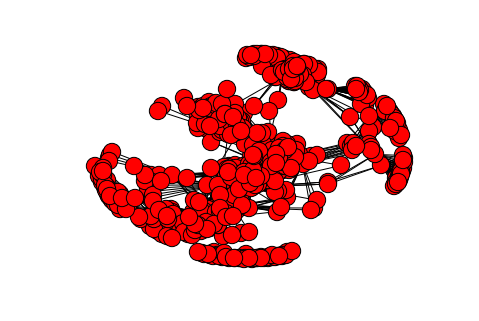


***********************
COMPONENT 0
***********************
Number of nodes  642
Number of edges  7852
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
YWHAEloss : 0.2 127
SNORD22loss : 0.19 119
DOC2B_RPH3AL_C17orf97_FAM101B_VPS53_FAM57A_GEMIN4_DBIL5P_GLOD4_RNMTL1_NXN_TIMM22_ABR_MIR3183_BHLHA9_TUSC5loss : 0.18 117
---
Writing nodes to:  output/BRCA_wustl-som-seg-gl-FDR--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  40
Number of edges  60
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
CDH1 : 0.97 38
PIK3CA : 0.56 22
GPT2_DNAJA2loss : 0.05 2
---
Writing nodes to:  output/BRCA_wustl-som-seg-gl-FDR--cpairs-min_cohort_filtered_network_comp1.txt


In [109]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [97]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********TRIPLET CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  7912
Pair info of triplets initialized
10284  triplets calculated in  7.27628803253
Including sorting time  7.29215693474
10284  of type  CooccurringCooccurringCooccurring
Triplets written to  output/BRCA_wustl-som-seg-gl-FDR--triplets-CooccurringCooccurringCooccurring.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-gl-FDR--triplets-CooccurringCooccurringCooccurring.txt
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
SNORD22loss has 1585
YWHAEloss has 818
NAA38gain has 797
DOC2B_RPH3AL_C1loss has	790
TOPAZ1_TCAIM_LIloss has	715
FAM230Closs has 710
RN7SL605Ploss has 695
RN7SL811Pgain has 678
RN7SL371Pgain has 588
NBEAloss has 388
MAB21L1_LINC004loss has	384
WSCD1loss has 366
RXFP2_EEF1DP3loss has 356
CRK_MYO1C_INPP5loss has	339
FAM155A_SNORD31loss has	337
DAOA_LINC00343_loss has	326
DNAH9_ZNF18_RPLloss has	326
MYH13_MYH8_MYH4loss has	323
LIG4_ABHD13_TNFloss has	322
AIPL1_FAM64A_KIloss has	314
CYB5D1_CHD3_KCNloss has	30